In [1]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
from collections import deque
import random
import torch
from torch import nn
import torch.nn.functional as F
from gymnasium.envs.toy_text.frozen_lake import generate_random_map
import time
import imageio
from IPython.display import Image

In [2]:
class DQN(nn.Module):
    def __init__(self, lake_size, in_channels, out_actions):
        super().__init__()
       
        self.conv1 = nn.Conv2d(in_channels=in_channels, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)

        self.fc1 = nn.Linear(64*lake_size*lake_size, 128)
        self.out = nn.Linear(128, out_actions)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))

        x = nn.Flatten()(x)

        x = F.relu(self.fc1(x))
        x = self.out(x)
        return x

In [3]:
class ReplayBuffer():
    def __init__(self, maxlen):
        self.buffer = deque([], maxlen=maxlen)
    
    def append(self, transition):
        self.buffer.append(transition)

    def sample(self, sample_size):
        return random.sample(self.buffer, sample_size)

    def __len__(self):
        return len(self.buffer)

In [4]:
def encode_game_state(desc, agent_index):

    lake_size = len(desc)
    
    # 4 channels: agent pos, hole pos, goal pos, tile pos
    channels = np.zeros((4, lake_size, lake_size), dtype=np.float32)

    # agent koordinaten bekommen
    agent_row = agent_index // lake_size
    agent_col = agent_index % lake_size

    # agent marker
    channels[0, agent_row, agent_col] = 1.0

    # desc durchgehen und werte setzen
    for row in range(lake_size):
        for col in range(lake_size):
            tile = desc[row][col]
            if tile == 'H':
                channels[1, row, col] = 1.0  # hole
            elif tile == 'G':
                channels[2, row, col] = 1.0  # goal
            elif tile in ('F', 'S'):
                channels[3, row, col] = 1.0  # frozen tile/start

    return torch.tensor(channels)


In [5]:
# hyperparameter
learning_rate = 0.0005
discount_factor = 0.9
network_sync_rate = 100
max_buffer_size = 10000
mini_batch_size = 64

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [6]:
def train(episodes, lake_size, is_slippery=False):
    
    start_time = time.time()

    buffer = ReplayBuffer(max_buffer_size)

    num_lake_tiles = lake_size * lake_size
    
    num_actions = 4

    # policy und target network erstellen
    policy_dqn = DQN(lake_size=lake_size, in_channels=4, out_actions=num_actions).to(device)
    target_dqn = DQN(lake_size=lake_size, in_channels=4, out_actions=num_actions).to(device)

    # target network und policy network gleich machen
    target_dqn.load_state_dict(policy_dqn.state_dict())

    # target network nur für inferenz gebraucht
    target_dqn.eval()

    optimizer = torch.optim.Adam(policy_dqn.parameters(), lr=learning_rate)

    rewards_per_episode = []
    epsilon_history = []
    losses = []
    
    total_steps = 0
    epsilon = 1.0
    
    for episode in range(episodes):
        
        desc = generate_random_map(size=lake_size)
        env = gym.make('FrozenLake-v1', desc=desc, is_slippery=is_slippery, render_mode=None)

        state, _ = env.reset()

        current_state_tensor = encode_game_state(desc, state).to(device)

        terminated = False
        truncated = False
        episode_reward = 0
        steps_in_episode = 0

        epsilon_history.append(epsilon)

        while not terminated and not truncated:
            # aktion nach epsilon greedy wählen
            if random.random() < epsilon:
                action = env.action_space.sample()  # zufällig
            else:
                with torch.no_grad():
                    q_values = policy_dqn(current_state_tensor.unsqueeze(0)).to(device)  # unsqueeze für batch dimension
                    action = torch.argmax(q_values).item()  # beste

            # step
            new_state, reward, terminated, truncated, _ = env.step(action)
            
            next_state_tensor = encode_game_state(desc, new_state).to(device)
            
            buffer.append((state, action, new_state, reward, terminated, desc))

            state = new_state
            current_state_tensor = next_state_tensor

            episode_reward += reward
            steps_in_episode += 1
            total_steps += 1

            # falls genug sample im buffer dann erst lernen
            if len(buffer) > mini_batch_size:
                mini_batch = buffer.sample(mini_batch_size)
                loss = optimize(mini_batch, policy_dqn, target_dqn, optimizer)
                if loss is not None:
                    losses.append(loss.item())

                # target network synchronisieren
                if total_steps % network_sync_rate == 0:
                    target_dqn.load_state_dict(policy_dqn.state_dict())

        rewards_per_episode.append(episode_reward)

        # epsilon über zeit reduzieren
        epsilon = max(0.05, epsilon * 0.999)
        # epsilon = max(0.05, epsilon - 1.0/(0.8*episodes))

        # log ausgabe alle 100 episoden
        if episode % 100 == 0:
            print(f"Episode {episode}/{episodes} | Episode Reward: {episode_reward:.3f} | Epsilon: {epsilon:.3f} | Steps: {steps_in_episode} | Buffer Size: {len(buffer)}")
    

    # training fertig
    env.close()
    end_time = time.time()
    print(f"Training fertig nach {end_time - start_time:.2f} Sekunden")

    # policy network speichern
    torch.save(policy_dqn.state_dict(), f"saved_cnn_model_dql_random_{lake_size}x{lake_size}.pt")

    return rewards_per_episode, losses, epsilon_history


In [7]:
def optimize(mini_batch, policy_dqn, target_dqn, optimizer):

    # daten aus mini batch extrahieren
    # (state, action, new_state, reward, terminated, desc)
    states = np.array([t[0] for t in mini_batch])
    actions = torch.LongTensor([t[1] for t in mini_batch]).view(-1, 1).to(device)
    next_states = np.array([t[2] for t in mini_batch])
    rewards = torch.FloatTensor([t[3] for t in mini_batch]).to(device)
    terminated_flags = torch.BoolTensor([t[4] for t in mini_batch]).to(device)
    descs = [t[5] for t in mini_batch]

    # alle game states encoden
    current_state_tensors = torch.stack([encode_game_state(desc, state) for desc, state in zip(descs, states)]).to(device)
    next_state_tensors = torch.stack([encode_game_state(desc, state) for desc, state in zip(descs, next_states)]).to(device)

    # q values für die actionen aus policy network bekommen
    current_q_values = policy_dqn(current_state_tensors).gather(1, actions).squeeze().to(device)

    # max q value aus target network bekommen
    with torch.no_grad():
         max_next_q_values = target_dqn(next_state_tensors).max(1)[0].to(device)

    # falls endzustand q value = 0
    max_next_q_values[terminated_flags] = 0.0

    # target q values berechnen
    target_q_values = rewards + (discount_factor * max_next_q_values).to(device)
    
    # l2 loss berechnen
    loss_fn = nn.MSELoss()
    loss = loss_fn(current_q_values, target_q_values)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    return loss

In [ ]:
def test(lake_size, is_slippery=False):
        
    # versuche gespeichertes model zu laden
    model_filename = f"saved_cnn_model_dql_random_{lake_size}x{lake_size}.pt"
    
    num_lake_tiles = lake_size * lake_size
    num_actions = 4

    # modell laden
    policy_dqn = DQN(lake_size=lake_size, in_channels=4, out_actions=num_actions).to(device)
    policy_dqn.load_state_dict(torch.load(model_filename))
    
    policy_dqn.eval()

    success_count = 0

    # zufälligen lake erstellen
    desc = generate_random_map(size=lake_size)
    env = gym.make('FrozenLake-v1', desc=desc, is_slippery=is_slippery, render_mode='rgb_array')
    
    state, _ = env.reset()
    terminated = False
    truncated = False
    frames = []

    # sonst fehlt erster frame
    frames.append(env.render())

    while(not terminated and not truncated):

        current_state_tensor = encode_game_state(desc, state).to(device)

        # beste aktion wählen
        with torch.no_grad():
            q_values = policy_dqn(current_state_tensor.unsqueeze(0)).to(device)
            action = torch.argmax(q_values).item()

        # aktion ausführen
        new_state, reward, terminated, truncated, _ = env.step(action)
        state = new_state

        frames.append(env.render())

    env.close()

    # gif speichern und anzeigen
    gif_path = f"dql_random_{lake_size}x{lake_size}.gif"
    imageio.mimsave(gif_path, frames, duration=1, loop=0)

    return gif_path


In [9]:
def plot_results(rewards_per_episode, losses, episodes, epsilon_history=[]):
    
    plt.figure(figsize=(18, 6))

    plt.subplot(1, 3, 1)
    sum_rewards = []
    for i in range(episodes):
        sum_rewards.append(np.sum(rewards_per_episode[max(0, i-100):(i+1)])/100)
    plt.plot(sum_rewards)
    plt.title('Avg Rewards pro 100 Episoden')
    plt.xlabel('Episoden')
    plt.ylabel('Avg Reward')
    plt.grid(True)

    plt.subplot(1, 3, 2)
    plt.plot(losses)
    plt.title('Losses')
    plt.xlabel('Updates')
    plt.ylabel('Loss')
    plt.grid(True)
    
    if epsilon_history:
        plt.subplot(1, 3, 3)
        plt.plot(epsilon_history, color="red")
        plt.title('Epsilon Decay')
        plt.xlabel('Episoden')
        plt.ylabel('Epsilon')
        plt.grid(True)

    plt.tight_layout()
    plt.show()
    

In [11]:
episodes = 5000
lake_size = 8

# training starten
rewards_per_episode, losses, epsilon_history = train(episodes=episodes, lake_size=lake_size, is_slippery=False)

# metriken plotten
plot_results(rewards_per_episode, losses, episodes, epsilon_history)

Episode 0/5000 | Episode Reward: 0.000 | Epsilon: 0.999 | Steps: 12 | Buffer Size: 12
Episode 100/5000 | Episode Reward: 0.000 | Epsilon: 0.904 | Steps: 10 | Buffer Size: 1505
Episode 200/5000 | Episode Reward: 0.000 | Epsilon: 0.818 | Steps: 42 | Buffer Size: 3068
Episode 300/5000 | Episode Reward: 0.000 | Epsilon: 0.740 | Steps: 44 | Buffer Size: 5330
Episode 400/5000 | Episode Reward: 0.000 | Epsilon: 0.670 | Steps: 13 | Buffer Size: 7700


KeyboardInterrupt: 

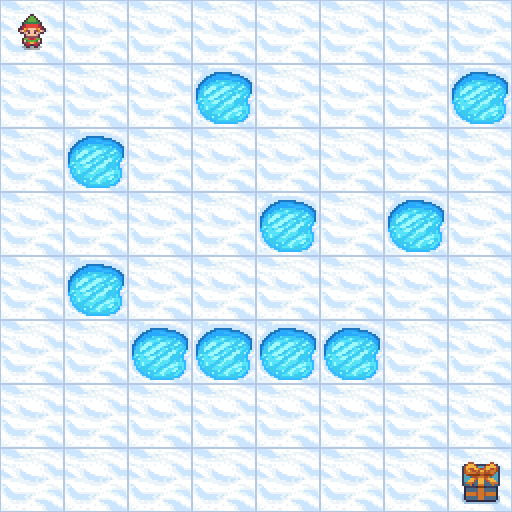

In [14]:
gif_path = test(lake_size=lake_size, is_slippery=False)

Image(filename=gif_path)